In [1]:
import datetime
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from dotenv import load_dotenv
from wordcloud import WordCloud, STOPWORDS

BACKGROUND_COLOR = '#f0efeb'
LOOKBACK_WEEKS = 104
load_dotenv()

plt.rcParams["font.family"] = ['Kristen ITC']
plt.rcParams["figure.facecolor"] = BACKGROUND_COLOR
plt.rcParams["axes.facecolor"] = BACKGROUND_COLOR
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.bottom"] = False

In [37]:
def startsWithDate(s):
    pattern = '^([0-2][0-9]|(3)[0-1][0-9])(\/)(([0-9])|((1)[0-2]))(\/)(\d{2}|\d{4})'
    result = re.match(pattern, s)
    if result:
        return True
    return False
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+[\]):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False
def getDataPoint(line):
    # line = 18/06/17, 22:47 - Loki: Why do you have 2 numbers, Banner?

    # splitLine = ['18/06/17, 22:47', 'Loki: Why do you have 2 numbers, Banner?']
    splitLine = line.split(' - ')

    dateTime = splitLine[0]  # dateTime = '18/06/17, 22:47'
    date, time = dateTime.split(', ')  # date = '18/06/17'; time = '22:47'

    # message = 'Loki: Why do you have 2 numbers, Banner?'
    message = ' '.join(splitLine[1:])

    # if startsWithAuthor(message):  # True
    # splitMessage = ['Loki', 'Why do you have 2 numbers, Banner?']
    splitMessage = message.split(': ')
    author = splitMessage[0]  # author = 'Loki'
    # message = 'Why do you have 2 numbers, Banner?'
    message = ' '.join(splitMessage[1:])
    # else:
    #     author = None
    return date, time, author, message

In [38]:
def createDataFrame(filename):
    df = open(filename , encoding="utf-8")
    lines = df.readlines()
    df.close()

    parsedData = []
    messageBuffer = []  # Buffer to capture intermediate output for multi-line messages
    # Intermediate variables to keep track of the current message being processed
    date, time, author = None, None, None

    # remove /n at the end of each line
    for index, line in enumerate(lines):
        lines[index] = line.strip()
    for line in lines:
        if (startsWithDate(line)):

            splitLine = line.split(' - ')
            dateTime = splitLine[0]
            date, time = dateTime.split(', ')

            message = ' '.join(splitLine[1:])
            if startsWithDate(line):
                # Check if the message buffer contains characters from previous iterations
                if len(messageBuffer) > 0:
                    # Save the tokens from the previous message in parsedData
                    parsedData.append([date, time, author, ' '.join(messageBuffer)])
                    
                # Clear the message buffer so that it can be used for the next message
                messageBuffer.clear()
                # Identify and extract tokens from the line
                date, time, author, message = getDataPoint(line)
                messageBuffer.append(message)  # Append message to buffer
            else:
                # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer
                messageBuffer.append(line)

    chat_df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])

    chat_df['datetime'] = pd.to_datetime(chat_df['Date'] + ' ' + chat_df['Time'],
                                    infer_datetime_format=True)
    chat_df['weekday'] = chat_df['datetime'].dt.day_name()
    chat_df['words'] = chat_df['Message'].apply(lambda s: len(s.split(' ')))
    chat_df['letters'] = chat_df['Message'].apply(lambda s: len(s))
    return chat_df

In [19]:
file=os.getenv('FILENAME')

In [39]:
chat_df=createDataFrame(file)
chat_df.head()

,Date,Time,Author,Message,datetime,weekday,words,letters
0,11/7/20,10:01 AM,Aarush,Best of luck brthr,2020-11-07 10:01:00,Saturday,4,18
1,11/7/20,10:14 AM,Anant,Best of luck bhai👍👍,2020-11-07 10:14:00,Saturday,4,19
2,11/7/20,10:26 AM,+91 84279 00289,Best of luck👍,2020-11-07 10:26:00,Saturday,3,13
3,11/7/20,10:26 AM,+91 81302 87811,screen dikhi thi abhi?? 😂,2020-11-07 10:26:00,Saturday,5,25
4,11/7/20,10:31 AM,H6 Ayush Kulshrestha,Nahi,2020-11-07 10:31:00,Saturday,1,4


# Visualisations

Most Messages done by

Messages per day

In [7]:
df = chat_df[chat_df['datetime'] > chat_df['datetime'].max() - pd.Timedelta(weeks=LOOKBACK_WEEKS)]
df["hour"] = chat_df["datetime"].dt.hour

In [8]:
df_daily_mess = df.groupby(by=df['datetime'].dt.date)['Message'].count().reset_index()
df_daily_mess["messsagecount_rm28"] = df_daily_mess["Message"].rolling(28, min_periods=13, center=True).mean()
df_daily_mess

,datetime,Message,messsagecount_rm28
0,2020-11-07,68,129.357143
1,2020-11-08,25,149.400000
2,2020-11-09,243,166.250000
3,2020-11-10,94,161.705882
4,2020-11-11,181,172.055556
5,2020-11-12,167,166.263158
6,2020-12-01,130,158.050000
7,2020-12-02,156,152.238095
8,2020-12-03,124,145.954545
9,2020-12-04,146,140.130435


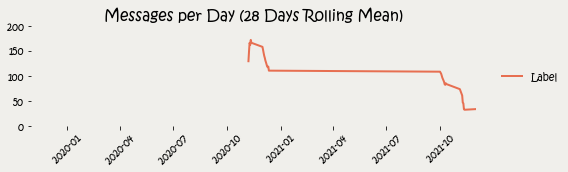

In [9]:
fig, ax = plt.subplots(figsize=(8,2.5))
sns.lineplot(data=df_daily_mess, x='datetime', y='messsagecount_rm28', ax=ax, label='Label', color='#e76f51', lw=2)
ax.set_ylim(0,200)
ax.set_xlim([datetime.date(2019, 11, 1), datetime.date(2021, 12, 1)])
ax.tick_params(axis='x', rotation=45)
ax.set_title("Messages per Day (28 Days Rolling Mean)", fontdict={"fontsize": 15})
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.legend(frameon = False, bbox_to_anchor=(1.04,0.5), loc="center left")
plt.tight_layout()

Messages per Daytime

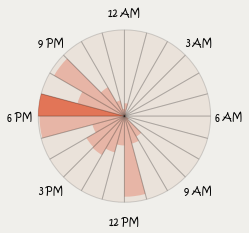

In [11]:
df_circle = df.groupby(by='hour')['Message'].count().reset_index()

time = df_circle['hour']
count = df_circle['Message']

c = np.zeros(24)
c[time] = count
count = c

f = plt.figure(figsize=(3.5, 3.5))
ax = plt.subplot(111, projection="polar")

x = np.arange(0, 2 * np.pi, 2 * np.pi / len(count)) + np.pi / len(count)

bars = ax.bar(x, count, width=2 * np.pi / len(count),
              alpha=0.4, color='#e76f51', bottom=0)

max_ind = np.argmax(count)
ax.bar(x[max_ind],count[max_ind], bottom=0,
       width=2 * np.pi / len(count), alpha=1, color='#e76f51')

ax.bar(x, np.max(count) * np.ones(len(count)), width=2 * np.pi / len(count),
    alpha=0.15, bottom=0, color='#cb997e', edgecolor="black")

ax.set_theta_direction(-1)
ax.grid(False)
ax.spines["polar"].set_visible(False)
ax.set_theta_offset(np.pi / 2)
ax.set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))
ticks = ["12 AM", "", "", "3 AM", "", "", "6 AM", "", "", "9 AM",
         "", "", "12 PM", "", "", "3 PM", "", "", "6 PM", "", "",
         "9 PM", "", ""]
ax.set_xticklabels(ticks)
plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()

Word Cloud

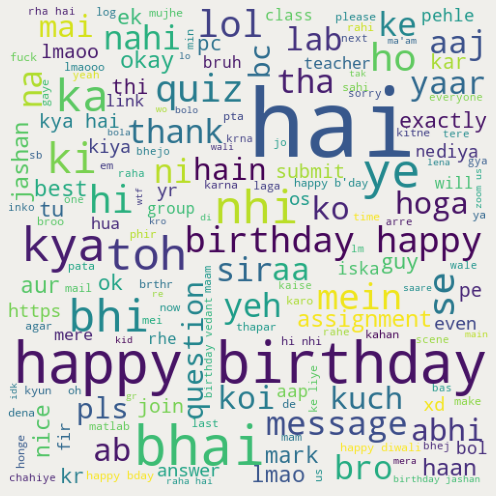

In [45]:
messages = [word.split() for word in chat_df["Message"].values]
words = [word.lower() for sublist in messages for word in sublist]

stopwords = STOPWORDS.update(['media', 'omitted', 'deleted','missed', 'voice', 'call'])

wordcloud = WordCloud(stopwords=stopwords, width=500, height=500,
                      background_color='#f0efeb', min_word_length=2,
                      min_font_size=10).generate(' '.join(words))
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout()